In [0]:
!nvidia-smi


Sat Dec  7 23:34:15 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!pip install -q kaggle

In [0]:
from google.colab import files

In [0]:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!echo '{"username":"karentree","key":"ff57b9d030d708de9af1a8da9558d6df"}' > /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [0]:
!kaggle datasets download -d karentree/artchanllage-genre-classification

100% 2.35G/2.36G [00:30<00:00, 129MB/s]
100% 2.36G/2.36G [00:30<00:00, 83.9MB/s]


In [0]:
!unzip artchanllage-genre-classification.zip

Archive:  artchanllage-genre-classification.zip
  inflating: genre/Abstract_Expressionism/Abstract_Expressionism_1.jpg  
  inflating: genre/Abstract_Expressionism/Abstract_Expressionism_10.jpg  
  inflating: genre/Abstract_Expressionism/Abstract_Expressionism_11.jpg  
  inflating: genre/Abstract_Expressionism/Abstract_Expressionism_12.jpg  
  inflating: genre/Abstract_Expressionism/Abstract_Expressionism_13.jpg  
  inflating: genre/Abstract_Expressionism/Abstract_Expressionism_14.jpg  
  inflating: genre/Abstract_Expressionism/Abstract_Expressionism_15.jpg  
  inflating: genre/Abstract_Expressionism/Abstract_Expressionism_16.jpg  
  inflating: genre/Abstract_Expressionism/Abstract_Expressionism_17.jpg  
  inflating: genre/Abstract_Expressionism/Abstract_Expressionism_18.jpg  
  inflating: genre/Abstract_Expressionism/Abstract_Expressionism_19.jpg  
  inflating: genre/Abstract_Expressionism/Abstract_Expressionism_2.jpg  
  inflating: genre/Abstract_Expressionism/Abstract_Expressionism_2

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random

import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import *
from keras.optimizers import *
from keras.applications import *
from keras.callbacks import *
from keras.initializers import *
from keras.preprocessing.image import ImageDataGenerator


from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)


Using TensorFlow backend.


In [0]:
os.remove('/content/genre/Northern_Renaissance/Northern_Renaissance_11.jpg')

In [0]:
artists_unique = pd.read_csv("/content/artists_unique.csv")



In [0]:
artists_unique.head()

,Unnamed: 0,name,years,genre,nationality,paintings,number_of_genre,underscore
0,0,Amedeo Modigliani,1884 - 1920,Expressionism,['Italian'],193,1,Amedeo_Modigliani
1,3,Claude Monet,1840 - 1926,Impressionism,['French'],73,1,Claude_Monet
2,5,Salvador Dali,1904 - 1989,Surrealism,['Spanish'],139,1,Salvador_Dali
3,7,Andrei Rublev,1360 - 1430,Byzantine_Art,['Russian'],99,1,Andrei_Rublev
4,8,Vincent van Gogh,1853 – 1890,Post-Impressionism,['Dutch'],877,1,Vincent_van_Gogh


In [0]:
genre_series = artists_unique.groupby('genre')['paintings'].sum()
genre_df = pd.DataFrame(genre_series, columns=['paintings'])


In [0]:
genre_df['genre_weight'] = genre_df['paintings'] /(genre_df.shape[0] * genre_df['paintings'])

In [0]:
genre_top5 = genre_df['paintings'].sort_values(ascending=False)[:15].index

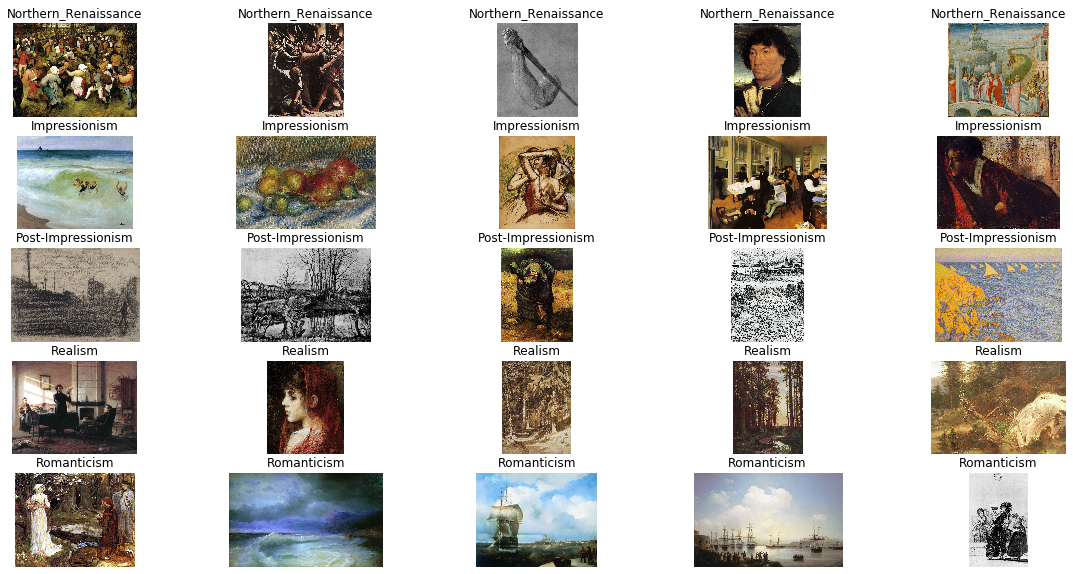

In [0]:
n = 5
fig, axes = plt.subplots(5, n, figsize=(20,10))

genre_dir = '/content/genre/'
for i, genre in enumerate(genre_top5):
  for j in range(n):
    random_image_file = random.choice(os.listdir(genre_dir+genre))
    #print(random_image_file)
    image = plt.imread(os.path.join(genre_dir,genre,random_image_file))
    axes[i][j].imshow(image)
    axes[i][j].axis('off')
    axes[i][j].set_title(genre)
plt.show()

**Data Augumentation**


In [0]:
# Initialize the data augmenter as an empty image data generator
aug = ImageDataGenerator(validation_split=0.2,
                         rescale=1./255.,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         shear_range=0.15,
                         horizontal_flip=True)

In [0]:
genre_list= genre_top5.to_list()

In [0]:
batch_size = 12
train_input_shape = (224, 224, 3)

train_generator = aug.flow_from_directory(directory=genre_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=genre_list
                                                   )
valid_generator = aug.flow_from_directory(directory=genre_dir,
                                               class_mode='categorical',
                                               target_size=train_input_shape[0:2],
                                               batch_size=batch_size,
                                               subset="validation",
                                               shuffle=True,
                                               classes=genre_list)
#??
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

Found 9801 images belonging to 15 classes.
Found 2443 images belonging to 15 classes.
Total number of batches = 816 and 203


**MODEL**

In [0]:
np.random.seed(1000)
n_class = 15

def CNN_model(img_shape=(224, 224, 3), n_classes=n_class, l2_reg=0.,
	weights=None):

  CNN = Sequential()

  #add model conv layer 1
  CNN.add(Conv2D(64, kernel_size=(3,3), activation='relu', input_shape=(224,224,3),padding = 'valid'))
  CNN.add(Activation('relu')) 
  CNN.add(MaxPooling2D(pool_size=(2, 2)))
  
  #add model conv layer 2  
  CNN.add(Conv2D(64, (2, 2))) 
  CNN.add(Activation('relu')) 
  CNN.add(MaxPooling2D(pool_size=(2, 2)))
  
  #add model conv layer 3
  CNN.add(Conv2D(64, (2, 2))) 
  CNN.add(Activation('relu')) 
  CNN.add(MaxPooling2D(pool_size=(2, 2))) 

  #add model conv layer 4
  CNN.add(Conv2D(64, (2, 2))) 
  CNN.add(Activation('relu')) 
  CNN.add(MaxPooling2D(pool_size=(2, 2))) 
  
  #add model conv layer 5
  CNN.add(Conv2D(64, (2, 2))) 
  CNN.add(Activation('relu')) 
  CNN.add(MaxPooling2D(pool_size=(2, 2))) 

  #flatten and fully connect
  CNN.add(Flatten()) 
  CNN.add(Dense(64)) 
  CNN.add(Activation('relu')) 
  CNN.add(Dropout(0.5)) 
    
  #fully connect
  CNN.add(Dense(64)) 
  CNN.add(Activation('relu')) 
  CNN.add(Dropout(0.5)) 

  #fully connect
  CNN.add(Dense(64)) 
  CNN.add(Activation('relu')) 
  CNN.add(Dropout(0.5)) 

  CNN.add(Dense(15)) 
  CNN.add(Activation('softmax')) 

  return CNN


In [0]:
cnn = CNN_model()


In [0]:
cnn.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [0]:
n_epoch = 30

early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

In [0]:
history1 = cnn.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr],
                              use_multiprocessing=True,
                              workers=16
                             )

Epoch 1/30
816/816 [==============================] - 272s 333ms/step - loss: 2.5528 - acc: 0.1260 - val_loss: 2.5027 - val_acc: 0.1289
Epoch 2/30
816/816 [==============================] - 277s 340ms/step - loss: 2.5151 - acc: 0.1312 - val_loss: 2.5043 - val_acc: 0.1386
Epoch 3/30
816/816 [==============================] - 275s 337ms/step - loss: 2.5103 - acc: 0.1355 - val_loss: 2.4997 - val_acc: 0.1386
Epoch 4/30
816/816 [==============================] - 274s 336ms/step - loss: 2.5102 - acc: 0.1332 - val_loss: 2.5012 - val_acc: 0.1370
Epoch 5/30
816/816 [==============================] - 273s 334ms/step - loss: 2.5095 - acc: 0.1332 - val_loss: 2.5002 - val_acc: 0.1300
Epoch 6/30
816/816 [==============================] - 271s 332ms/step - loss: 2.5090 - acc: 0.1337 - val_loss: 2.5063 - val_acc: 0.1386
Epoch 7/30
816/816 [==============================] - 273s 334ms/step - loss: 2.5078 - acc: 0.1326 - val_loss: 2.5003 - val_acc: 0.1374
Epoch 8/30
816/816 [============================

In [0]:
from keras.callbacks import CSVLogger
csv_logger = CSVLogger("/content/cnn_history_genre_log.csv", append=True)


In [0]:
!cp /content/cnn_history_genre_log.csv /content/gdrive/My\ Drive/

cp: cannot stat '/content/cnn_history_genre_log.csv': No such file or directory


In [0]:
path = "/content/CNN_model_genre_1114_scratch.h5" 
cnn.save_weights('/content/_model_genre_1114_scratch.h5')


In [0]:
his = pd.DataFrame(history1.history) 

In [0]:
his.to_csv('/content/history.csv')